In [28]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from optimization_tuned import (epsilon_nondominated,HypervolumeMetric, Hypervolume, ArchiveLogger, 
                                AbstractConvergenceMetric, EpsilonProgress)

from optimization_tuned import epsilon_nondominated, to_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    SequentialEvaluator,
    ScalarOutcome
)
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
#from ema_workbench.em_framework.optimization import EpsilonProgress

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator,
                           Scenario, Policy, perform_experiments, ema_logging)
from ema_workbench.em_framework.optimization import HyperVolume


ema_logging.log_to_stderr(ema_logging.INFO)

import pickle
warnings.filterwarnings("ignore")

## Robustness Metrics

### Setup using Delft Blue optimizer results

In [2]:
#Defining the model
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [3]:
#Load results coming from Delft Blue for scenario 0
scenario_0_results = []
for i in range(6):
    with open(f"DB_results\Seed-{i}Scen-0.pkl", 'rb') as file:
        seed_result = pickle.load(file)
        scenario_0_results.append(seed_result[0])
        
#Load results coming from Delft Blue for scenario 1      
scenario_1_results = []
for i in range(6):
    with open(f"DB_results\Seed-{i}Scen-1.pkl", 'rb') as file:
        seed_result = pickle.load(file)
        scenario_1_results.append(seed_result[0])


In [4]:
#Defining the problem
problem = to_problem(dike_model, searchover="levers")

In [5]:
#Make sure only the relevant policies coming from Open Exploration are taken into account in the problem

levers_to_delete = ["A.1_DikeIncrease 0","A.1_DikeIncrease 1","A.1_DikeIncrease 2","A.2_DikeIncrease 0",
                    "A.2_DikeIncrease 1","A.2_DikeIncrease 2","A.3_DikeIncrease 1","A.3_DikeIncrease 2","A.4_DikeIncrease 0",
                    "A.4_DikeIncrease 1","A.4_DikeIncrease 2","A.5_DikeIncrease 2","0_RfR 0","0_RfR 1","0_RfR 2","1_RfR 0",
                    "1_RfR 1","1_RfR 2","4_RfR 0","4_RfR 1","4_RfR 2"]

for lever in levers_to_delete:
    problem.parameters.__delitem__(lever)

#Update the number of levers of the problem instance, because this does not get updated automatically
problem.nvars = 10

### Merge Seeds

In [6]:
#Merge the results from the different seeds for each of the two scenarios
epsilons = [0.05] * len(dike_model.outcomes)

merged_results_0 = epsilon_nondominated(scenario_0_results, epsilons, problem)
merged_results_1 = epsilon_nondominated(scenario_1_results, epsilons, problem)

### Remove duplicate candidate strategies from the two scenarios

In [7]:
#Add the two dataframes together
merged_results = pd.concat([merged_results_0, merged_results_1], axis=0)

In [8]:
#Get rid of duplicate strategies that occur in both scenarios
unique_results = merged_results.drop_duplicates(subset=merged_results.columns[:10])

## Policy setup



In [9]:
#We add a manual constraint, as we want no evacuation, so also no evacuation costs
filter = (unique_results['Expected Evacuation Costs'] < 0.001)
policies = unique_results[filter]

#Just keep in the policies, and get rid of the outcomes
policies = policies.drop([o.name for o in dike_model.outcomes], axis=1)
old_index_policies = policies
policies = policies.reset_index(drop=True)

In [10]:
from ema_workbench import Policy

policy = {str(p): 0 for p in dike_model.levers}

policies_to_evaluate = []
for index, row in policies.iterrows():
    for p in policies.columns:
        policy[p] = row[p]
    policies_to_evaluate.append(Policy(f'Policy{index}', **policy))

# Running candidate policies for 4000 scenarios

In [11]:
# Run 4000 scenarios for each of the policy options
n_scenarios = 6000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 6000 scenarios * 15 policies * 1 model(s) = 90000 experiments
100%|██████████████████████████████████| 90000/90000 [3:18:13<00:00,  7.57it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [ ]:
# # Run 4000 scenarios for each of the policy options
# n_scenarios = 6000
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies_to_evaluate)# Run 4000 scenarios for each of the policy options
# n_scenarios = 6000
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(n_scenarios,
#                                             policies_to_evaluate)

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 6000 scenarios * 15 policies * 1 model(s) = 90000 experiments
 80%|███████████████████████████▏      | 71914/90000 [2:39:14<44:31,  6.77it/s]

In [25]:
experiments, outcomes = results

In [13]:
#Saving the results just to be sure
outcomes2 = pd.DataFrame.from_dict(outcomes)
outcomes2.to_csv('Results/Robustness_outcomes.csv')
experiments.to_csv('Results/Robustness_experiments.csv')

# Signal to Noise ratio

In [26]:
#Function to calculate the signal to noise ratio
#We want all our signal to noise ratios to be minimized
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [15]:
#Calculate signal to noise scores for every candidate policy
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T


### Full colour signal to noise plot

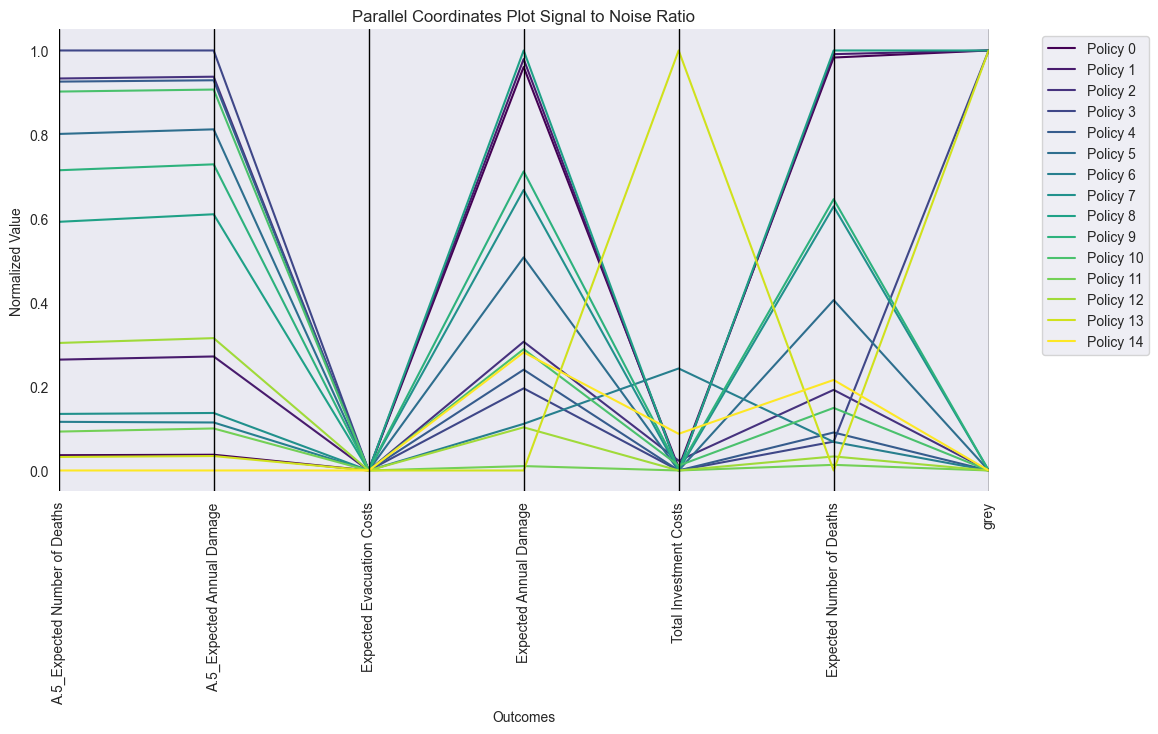

In [16]:
#Plotting with seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

data1 = scores.copy()

# Normalize the data 
zero_columns = data1.columns[(data1 == 0).all()]
data_normalized1 = data1.copy()
for col in data1.columns:
    if col not in zero_columns:
        data_normalized1[col] = (data1[col] - data1[col].min()) / (data1[col].max() - data1[col].min())

data_normalized1['class'] = ['Policy ' + str(i) for i in range(len(data_normalized1))]

#Create extra column to indicate grey lines in plot, if they have at least one value bigger than 0.95
cols = ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage','Expected Evacuation Costs',
        'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']
data_normalized1['grey'] = data_normalized1.apply(lambda row: 1 if any(row[cols] > 0.95) else 0, axis=1)

plt.figure(figsize=(12, 6))
parallel_coordinates(data_normalized1, 'class', colormap=plt.get_cmap("viridis"))

plt.title("Parallel Coordinates Plot Signal to Noise Ratio")
plt.xlabel("Outcomes")
plt.ylabel("Normalized Value")

ax = plt.gca()

#Makes sure that x labels are vertically positioned
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#Makes sure the legend is on the right side of the graph 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#Remove the background grid
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

### Filtered signal to noise plot with grey lines

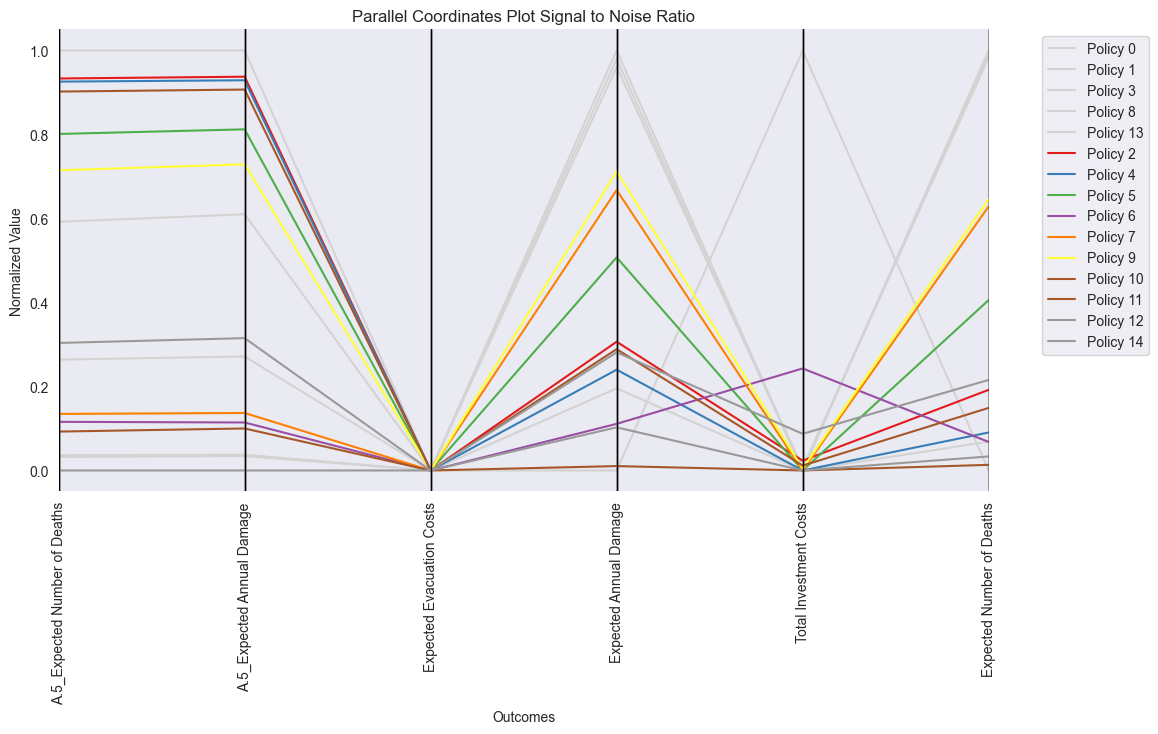

In [17]:
#Normalize the data
zero_columns = data1.columns[(data1 == 0).all()]
data_normalized1 = data1.copy()
for col in data1.columns:
    if col not in zero_columns and col != 'grey':
        data_normalized1[col] = (data1[col] - data1[col].min()) / (data1[col].max() - data1[col].min())

data_normalized1['class'] = ['Policy ' + str(i) for i in range(len(data_normalized1))]

#Create extra column to indicate grey lines in plot, if they have at least one value bigger than 0.95
cols = ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage','Expected Evacuation Costs',
        'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']
data_normalized1['grey'] = data_normalized1.apply(lambda row: 1 if any(row[cols] > 0.95) else 0, axis=1)
cols.append('class')

plt.figure(figsize=(12, 6))

#Create two loose dataframes to indicate whether line should be grey or not
grey = data_normalized1[data_normalized1['grey'] == 1]
non_grey = data_normalized1[data_normalized1['grey'] == 0]

#Plot grey and coloured lines separately
parallel_coordinates(grey.loc[:, cols], 'class', color='lightgrey', )
parallel_coordinates(non_grey.loc[:, cols], 'class', colormap=plt.get_cmap("Set1"))

plt.title("Parallel Coordinates Plot Signal to Noise Ratio")
plt.xlabel("Outcomes")
plt.ylabel("Normalized Value")

ax = plt.gca()

#Makes sure that x labels are vertically positioned
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#Makes sure the legend is on the right side of the graph 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#Remove the background grid
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

In [18]:
#Create a list of the selected candidate policies after filtering on worst signal to noise scores
pols_after_sn = []
for i in non_grey.index:
    pols_after_sn.append(i)


# Max Regret

In [19]:
#Function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [20]:
#Calculate max regret for every policy
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    #Create the dataframe with useful information
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    #Only take into account policies that were selected from the signal to noise outcomes
    data = data[data['policy'].isin(pols_after_sn)]
    
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    
    #Get difference between max and actual values in the row
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

### Max Regret Heatmap

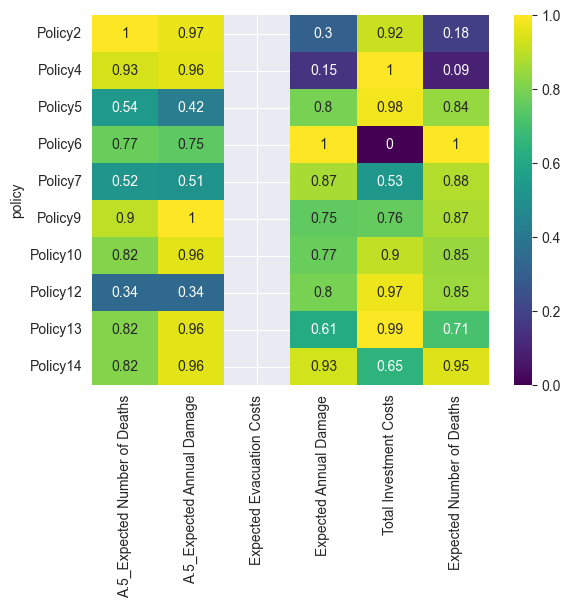

In [21]:
#Create heatmap
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret / max_regret.max(), cmap='viridis', annot=True)
plt.show()


### Filtered Max Regret plot with grey lines

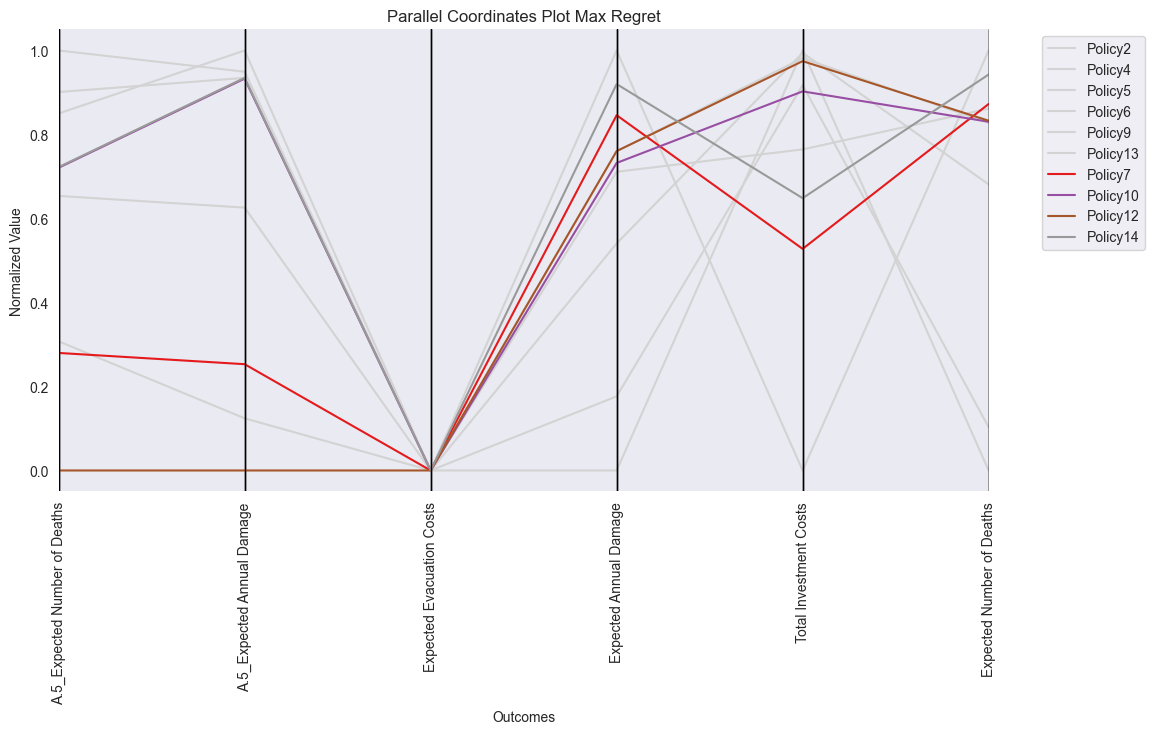

In [22]:
data = max_regret.copy()

plt.style.use({'figure.facecolor': 'white'})

# Normalize the data 
zero_columns = data.columns[(data == 0).all()]
data_normalized = data.copy()
for col in data.columns:
    if col not in zero_columns:
        data_normalized[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
data_normalized = data_normalized.reset_index()

#Filter out rows that have a max regret value of higher than the threshold
cols1 = ['A.5_Expected Number of Deaths', 'A.5_Expected Annual Damage','Expected Evacuation Costs',
        'Expected Annual Damage', 'Total Investment Costs', 'Expected Number of Deaths']
data_normalized['grey'] = data_normalized.apply(lambda row: 1 if any(row[cols1] > 0.975) else 0, axis=1)
cols1.append('policy')

plt.figure(figsize=(12, 6))

#Create two seperate dataframes to plot grey and coloured lines
grey1 = data_normalized[data_normalized['grey'] == 1]
non_grey1 = data_normalized[data_normalized['grey'] == 0]

#Plot grey and coloured lines seperately
parallel_coordinates(grey1.loc[:, cols1], 'policy', color='lightgrey', )
parallel_coordinates(non_grey1.loc[:, cols1], 'policy', colormap=plt.get_cmap("Set1"))


plt.title("Parallel Coordinates Plot Max Regret")
plt.xlabel("Outcomes")
plt.ylabel("Normalized Value")

ax = plt.gca()

#Makes sure that x labels are vertically positioned
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#Makes sure the legend is on the right side of the graph 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#Remove the background grid
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()

## Save final policies

In [23]:
#Create a list of the final selected candidate policies after filtering on worst max regret scores
pols_final = []
for i in non_grey1.policy:
    pols_final.append(i)

In [24]:
#Save the final output
experiments_final = experiments[experiments['policy'].isin(pols_final)]
outcomes_final = outcomes2.iloc[[i for i in experiments_final.index], :]

experiments_final.to_csv('Results/Final_policies_experiments.csv')
outcomes_final.to_csv('Results/Final_policies_outcomes.csv')

In [31]:
ex = pd.read_csv('Results/Final_policies_experiments.csv')

In [32]:
ex

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,24,40,170.538659,1.5,0.583069,138.345147,1.5,0.286781,154.875138,1.5,...,0,0,0,0,0,0,0,0,Policy6,dikesnet
1,25,115,251.874865,10.0,0.779778,95.495208,10.0,0.931142,85.085413,1.0,...,0,0,0,0,0,0,0,1,Policy6,dikesnet
2,26,9,39.507619,10.0,0.250365,199.710163,1.0,0.006780,297.076748,10.0,...,0,0,0,0,0,0,0,2,Policy6,dikesnet
3,27,96,297.175593,1.0,0.120529,349.014358,1.0,0.526528,219.155730,1.5,...,0,0,0,0,0,0,0,3,Policy6,dikesnet
4,28,40,170.538659,1.5,0.583069,138.345147,1.5,0.286781,154.875138,1.5,...,0,0,0,0,0,0,0,0,Policy7,dikesnet
5,29,115,251.874865,10.0,0.779778,95.495208,10.0,0.931142,85.085413,1.0,...,0,0,0,0,0,0,0,1,Policy7,dikesnet
6,30,9,39.507619,10.0,0.250365,199.710163,1.0,0.006780,297.076748,10.0,...,0,0,0,0,0,0,0,2,Policy7,dikesnet
7,31,96,297.175593,1.0,0.120529,349.014358,1.0,0.526528,219.155730,1.5,...,0,0,0,0,0,0,0,3,Policy7,dikesnet
8,40,40,170.538659,1.5,0.583069,138.345147,1.5,0.286781,154.875138,1.5,...,0,0,0,0,0,0,0,0,Policy10,dikesnet
9,41,115,251.874865,10.0,0.779778,95.495208,10.0,0.931142,85.085413,1.0,...,0,0,0,0,0,0,0,1,Policy10,dikesnet
